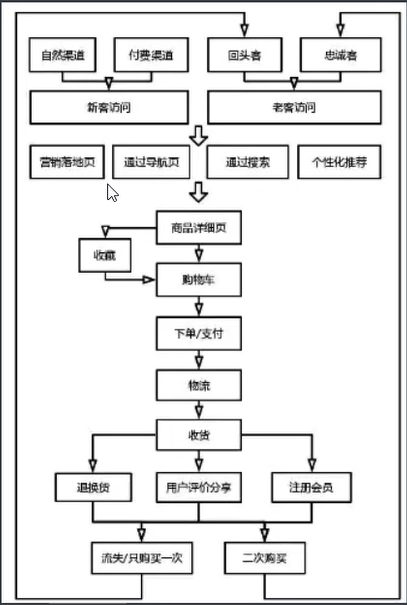

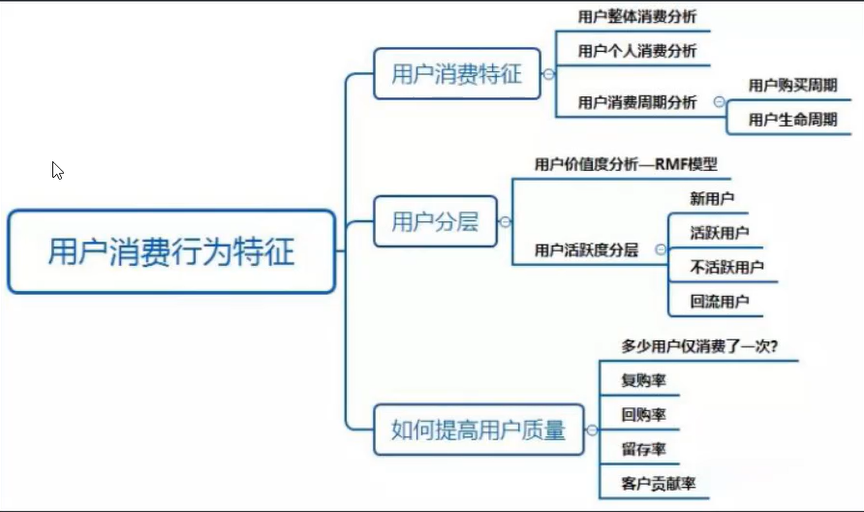

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

%matplotlib inline
plt.style.use('ggplot')    # 更改绘图风格， R语言绘图库的风格
plt.rcParams['font.sans-serif'] = ['SimHei'] # 用来正常显示中文标签

### 1、导入数据, 初步分析数据

In [2]:
# Load data
columns = ['user_id', 'order_dt', 'order_products', 'order_amount']
df = pd.read_table('data/CDNOW_master.txt', sep='\s+', names=columns)    # sep ='\s+'  匹配任意个空格
df.head()

# 1. 日期格式需要转换
# 2. 存在同一个用户一天内多次购买的行为

,user_id,order_dt,order_products,order_amount
0,1,19970101,1,11.77
1,2,19970112,1,12.00
2,2,19970112,5,77.00
3,3,19970102,2,20.76
4,3,19970330,2,20.76


In [3]:
df.describe()

# 1. 用户平均每笔订单购买2.4个商品, 标准差2.3, 稍微有点波动, 属于正常.
#   然而 75% 分位数的时候， 说明绝大多数订单的购买量都不多， 围绕在 2~3 个产品左右
# 2.购买金额，反映出大部分订单消费金额集中在中小额，30~45左右

,user_id,order_dt,order_products,order_amount
count,69659.000000,6.965900e+04,69659.000000,69659.000000
mean,11470.854592,1.997228e+07,2.410040,35.893648
std,6819.904848,3.837735e+03,2.333924,36.281942
min,1.000000,1.997010e+07,1.000000,0.000000
25%,5506.000000,1.997022e+07,1.000000,14.490000
50%,11410.000000,1.997042e+07,2.000000,25.980000
75%,17273.000000,1.997111e+07,3.000000,43.700000
max,23570.000000,1.998063e+07,99.000000,1286.010000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69659 entries, 0 to 69658
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   user_id         69659 non-null  int64  
 1   order_dt        69659 non-null  int64  
 2   order_products  69659 non-null  int64  
 3   order_amount    69659 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 2.1 MB


### 2、数据预处理, 用户整体消费分析(按月)

In [5]:
df['order_date'] = pd.to_datetime(df['order_dt'], format='%Y%m%d')
# format 参数： 按照指定的格式去匹配要转换的数据列
# %Y: 四位的年份    %m: 两位月份    %d: 两位日期
# %y: 两位的年份    %h: 小时   %M: 分钟    %s: 两位 秒

# 将 order_date 转化成精度为月份的 PeriodIndex 对象
df['month'] = df['order_date'].dt.to_period('M')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69659 entries, 0 to 69658
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   user_id         69659 non-null  int64         
 1   order_dt        69659 non-null  int64         
 2   order_products  69659 non-null  int64         
 3   order_amount    69659 non-null  float64       
 4   order_date      69659 non-null  datetime64[ns]
 5   month           69659 non-null  period[M]     
dtypes: datetime64[ns](1), float64(1), int64(3), period[M](1)
memory usage: 3.2 MB


Text(0.5, 1.0, '每月的消费人数')

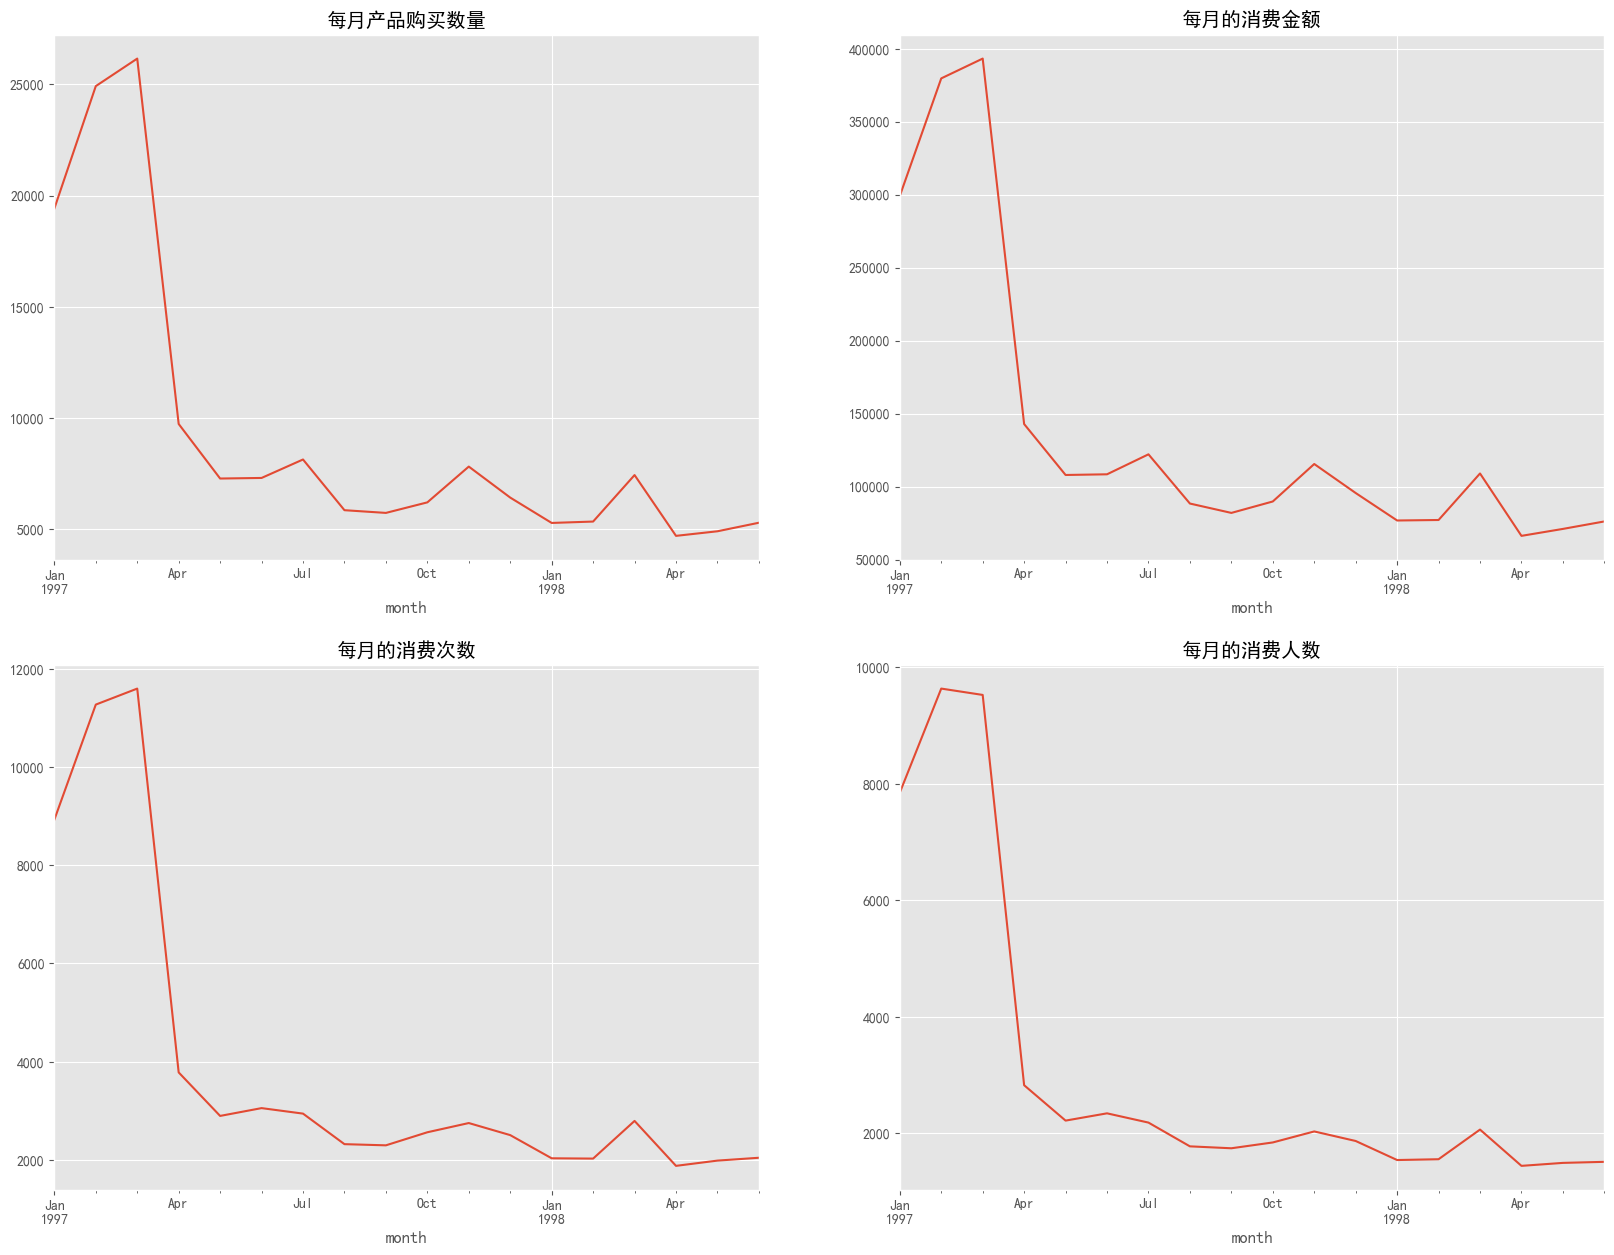

In [6]:
# 用户整体消费趋势分析 【按月份】
# 按月份统计 产品购买数量, 消费金额, 消费次数, 消费人数

plt.figure(figsize=(20, 15))    # 单位: 英寸

plt.subplot(221)    # 两行两列的第一个图
df.groupby('month')['order_products'].sum().plot()     # 默认折线图
plt.title('每月产品购买数量')

plt.subplot(222)    # 两行两列的第二个图
df.groupby('month')['order_amount'].sum().plot()     # 默认折线图
plt.title('每月的消费金额')

plt.subplot(223)    # 两行两列的第三个图
df.groupby('month')['user_id'].count().plot()     # 默认折线图
plt.title('每月的消费次数')

# 统计每月的消费人数 【根据user_id 进行去重统计, 再计算个数】
plt.subplot(224)    # 两行两列的第三个图
df.groupby('month')['user_id'].apply(lambda x:len(x.drop_duplicates())).plot()     # 默认折线图
plt.title('每月的消费人数')

# 分析结果：
# 图一 : 前 3 个月销量非常的高 [average 2.3W]， 而之后的销量较为稳定 [8K]， 并且稍微呈现下降的趋势
# 图二 : 前 3 个月消费金额较高, 与消费数量成正比例关系, 3月份过后下降严重， 并呈现下降趋势, 
    # 思考原因  1 : 跟月份有关, 在我国 1, 2, 3 月份处于春节前后。 
    #          2 : 公司在 1, 2, 3 月份的时候 是否加大了促销力度
# 图三 : 前三个月订单数在10000左右，后续月份的平均消费单数在2500左右
# 图四 : 前三个月消费人数在8000~10000左右，后续平均消费消费在2000不到的样子

# 总结 : 所有数据显示, 97年前3个月消费事态异常, 后续趋于常态化

### 3、 用户个体消费分析
    
    a. 用户消费金额，消费次数(产品数量)描述统计 

In [7]:
df = df[['user_id', 'order_dt', 'order_products', 'order_amount']]
user_group = df.groupby('user_id').sum()
print(user_group.describe())


# 从用户的角度: 用户数量23570个, 每个用户平均购买7个CD, 但是中位数只有3,
#              并且最大购买量为1033, 平均值大于中位数, 属于典型的右偏分布 [替购买量 < 7 的用户背锅 ]

# 从消费金额角度:平均用户消费106, 中位数43, 并且存在士豪用户13990, 结合分位数和最大值来看, 平均数与75%分位数几乎相等
#               属于典型的右偏分布，说明存在小部分用户(后面的25%)高额消费(这些用户需要给消费金额<106的用户背锅, 只有这样才能使平均数维持在106)              


           order_dt  order_products  order_amount
count  2.357000e+04    23570.000000  23570.000000
mean   5.902627e+07        7.122656    106.080426
std    9.460684e+07       16.983531    240.925195
min    1.997010e+07        1.000000      0.000000
25%    1.997021e+07        1.000000     19.970000
50%    1.997032e+07        3.000000     43.395000
75%    5.992125e+07        7.000000    106.475000
max    4.334408e+09     1033.000000  13990.930000


<Axes: xlabel='order_products', ylabel='order_amount'>

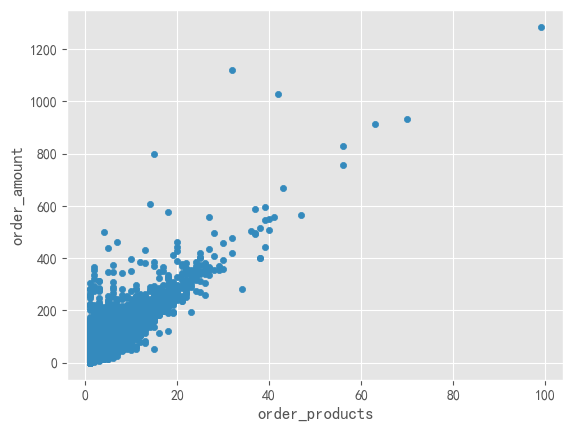

In [8]:
# 绘制每个用户的产品的购买最与消费金额散点图
df.plot(kind='scatter', x='order_products', y='order_amount')


# 从图中可知, 用户的消费金额与购买量呈现线性趋势, 每个商品均价15左右
# 订单的极值点比较少(消费金额 > 1000, 或者购买量大于60)，对于样本来说影响不大，可以忽略不记。


    b. 用户消费分布图

Text(0.5, 0, '每个user_id购买的数量')

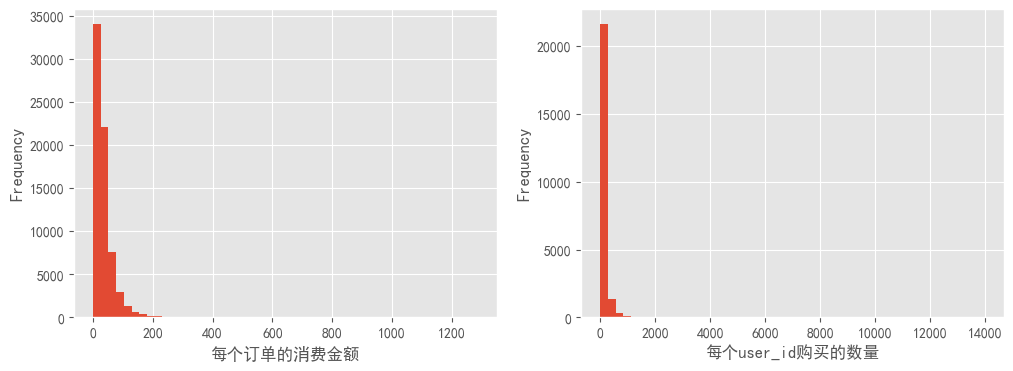

In [9]:
plt.figure(figsize=(12,4))
plt.subplot(121)

df['order_amount'].plot(kind='hist', bins=50)   # bins : 区间分数， 影响柱子的宽度， 值越大， 柱子越细。 宽度=（列最大值-最小值）/bins
plt.xlabel('每个订单的消费金额')

# 消费金额在100以内的订单占据了绝大多数


plt.subplot(122)
df.groupby('user_id')['order_amount'].sum().plot(kind='hist', bins=50)
plt.xlabel('每个user_id购买的数量')

# 图二可知，每个用户购买数量非常小，集中在50以内
# 两幅图得知，我们的用户主要是消费金额低，并且购买小于50的用户人数占据大多数
#  [ 在电商领域是非常正常的现象 ]

    C. 用户累计消费金额占比分析(用户的贡献度)

In [10]:
#  用户分组, 获取消费金额,  求和,  排序, 重置索引
user_cumsum = df.groupby('user_id')['order_amount'].sum().sort_values().reset_index()
user_cumsum


,user_id,order_amount
0,10175,0.00
1,4559,0.00
2,1948,0.00
3,925,0.00
4,10798,0.00
...,...,...
23565,7931,6497.18
23566,19339,6552.70
23567,7983,6973.07
23568,14048,8976.33


In [11]:
# 每个用户消费金额累加
#   累加器举例:

# a = [1, 2, 3, 4, 5, 6, 7]   
# print(np.cumsum(a))             # cumsum: 累积总和

user_cumsum['amount_cumsum'] = user_cumsum['order_amount'].cumsum()
user_cumsum.tail()

,user_id,order_amount,amount_cumsum
23565,7931,6497.18,2463822.60
23566,19339,6552.70,2470375.30
23567,7983,6973.07,2477348.37
23568,14048,8976.33,2486324.70
23569,7592,13990.93,2500315.63


In [12]:

amount_total = user_cumsum['amount_cumsum'].max()    #  消费金额总值
user_cumsum['prop'] = user_cumsum.apply(lambda x:x['amount_cumsum']/amount_total, axis=1)    # 前  XX 用户的总贡献率
user_cumsum.tail()

,user_id,order_amount,amount_cumsum,prop
23565,7931,6497.18,2463822.60,0.985405
23566,19339,6552.70,2470375.30,0.988025
23567,7983,6973.07,2477348.37,0.990814
23568,14048,8976.33,2486324.70,0.994404
23569,7592,13990.93,2500315.63,1.000000


<Axes: >

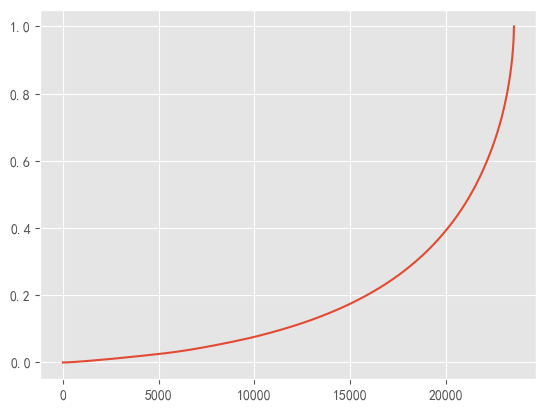

In [13]:
user_cumsum['prop'].plot()

# 由图分析可知,前20000名用户贡献总金额的40%, 剩余3500名用户贡献了60%。(2/8原则)

### 4. 用户消费行为

    a. 收购时间

<Axes: xlabel='order_date'>

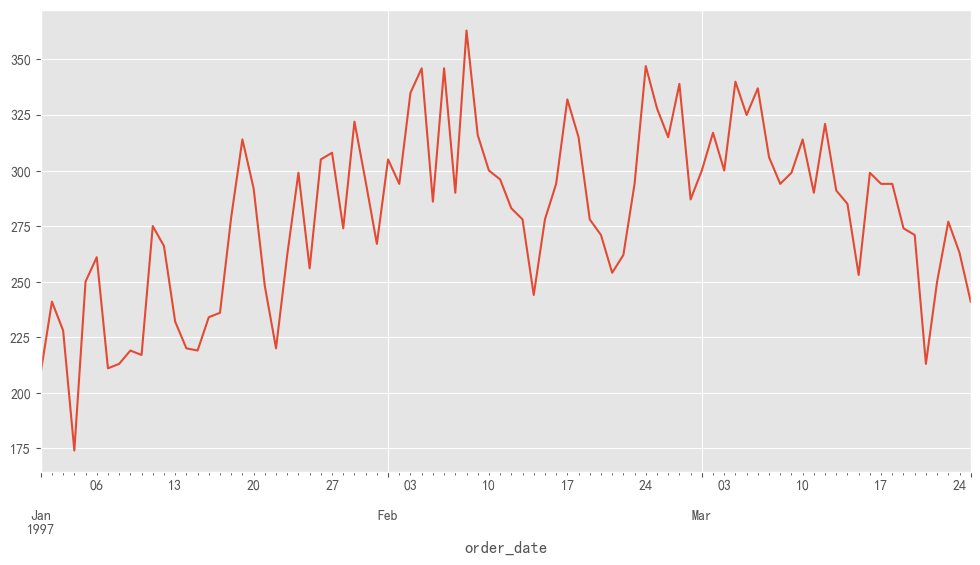

In [14]:
# 用户分组, 取最小值, 即为收购时间
df['order_date'] = pd.to_datetime(df['order_dt'], format='%Y%m%d')
df['month'] = df['order_date'].dt.to_period('M')
plt.figure(figsize=(12, 6))
counts = df.groupby('user_id')['order_date'].min().value_counts().sort_index()  # 按照日期升序排列
counts.plot(kind='line')

# 由图可知, 首次购买的用户量在1月1号~2月10号呈明显上升趋势, 后续开始逐步下降
# 猜测，有可能是公司产品的推广力度或者价格调整所致

    b. 最后一次购买时间 

<Axes: xlabel='order_date'>

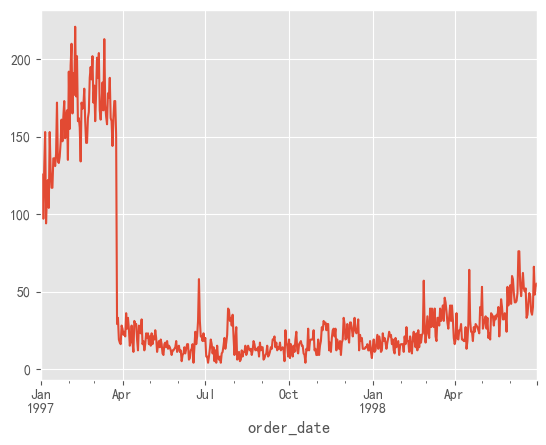

In [15]:
df.groupby('user_id')['order_date'].max().value_counts().sort_index().plot()

# 大多数使用户最后一次购买时间集中在前3个月, 说明缺少忠诚用户
# 随着时间的推移，最后一次购买商品的用户量呈现上升趋势, 
# 猜测:  这份数据选择是的前三个月消费的用户在后面 18 个月的跟踪记录


### 5. 用户分层

<pre>
<strong>构建RFM 模型</strong>

为了进行精细化运营，可以利用REM模型对用户价值指数(衡量历史到当前用户贡献的收益)进行计算，其中:

    - R:(Recency，最近一次消费)，R值越大，表示客户交易发生的日期越久，反之则交易发生的日期越近。
    - F:(Frequency，消费频率)，F值越大，表示客户交易越频繁，反之则表示客户交易不够活跃(此处我们选择购买产品数量作F)
    - M:(Monetary，消费金额)，M值越大，表示客户价值越高，反之则表示客户价值越低根据上述三个维度，对客户做细分

</pre>

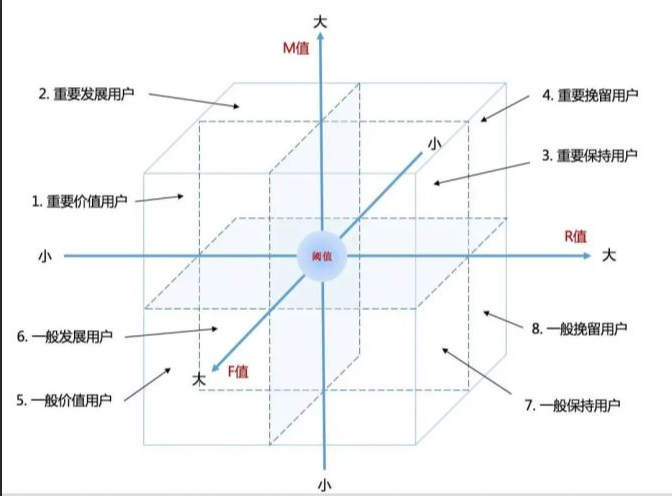


<pre>
<strong><i>透视表</i></strong> 是一种可以对数据动态排布并且分类汇总的表格格式。或许大多数人都在Excel使用过数据透视表，也体会到它的强大功能，而在pandas中它被称作pivot_table。

为什么要使用 pivot_table ???
    灵活性高，可以随意定制你的分析计算要求
    脉络清晰易于理解数据
    操作性强，报表神器

</pre>

    a. 构建 RFM 模型

In [16]:
# 透视表的使用 (index: 相当于 groupby, values:去除的数据列， aggfunc: 聚合函数[key值必须存在于values列中, 并且必须跟随有效的聚合函数])

rfm = df.pivot_table(index='user_id',
                     values=['order_products', 'order_amount', 'order_date'],
                     aggfunc={
                         'order_date':'max',        # 最后一次购买
                         'order_products':'sum',    # 购买产品的总数量
                         'order_amount':'sum'       # 消费总金额
                     }
)
rfm.head()

,order_amount,order_date,order_products
user_id,,,
1,11.77,1997-01-01,1
2,89.00,1997-01-12,6
3,156.46,1998-05-28,16
4,100.50,1997-12-12,7
5,385.61,1998-01-03,29


In [17]:
# 用每个用户的最后一次购买时间-日期列中的最大值, 最后再转换成天数, 小数保留一位
rfm['R']=-(rfm['order_date'] - rfm['order_date'].max())/np.timedelta64(1,'D')    # 取相差的天数， 保留一位小数
rfm.rename(columns={'order_products':'F', 'order_amount':'M'}, inplace=True)
rfm.head()

,M,order_date,F,R
user_id,,,,
1,11.77,1997-01-01,1,545.0
2,89.00,1997-01-12,6,534.0
3,156.46,1998-05-28,16,33.0
4,100.50,1997-12-12,7,200.0
5,385.61,1998-01-03,29,178.0


In [18]:
# RFM 计算方式: 每一列数据减去数据所在列的平均值, 有正有负, 根据结果值与 1 做比较，如果 >= 1，设置为 1 ，否则 0

def rfm_func(x):
    level = x.apply(lambda x:'1' if x>=1 else '0')
    label = level['R'] + level['F'] + level['M'] 
    d = {
        '111':'重要价值客户',
        '011':'重要保持客户',
        '101':'重要发展客户',
        '001':'重要挽留客户',
        '110':'一般价值客户',
        '010':'一般保持客户',
        '100':'一般发展客户',
        '000':'一般挽留客户'  
    }
    result = d[label]
    return result


# rfm['R'] - rfm['R'].mean()
rfm['label'] = rfm[['R', 'M', 'F']].apply(lambda x:x-x.mean()).apply(rfm_func, axis = 1)
rfm.head()

,M,order_date,F,R,label
user_id,,,,,
1,11.77,1997-01-01,1,545.0,一般发展客户
2,89.00,1997-01-12,6,534.0,一般发展客户
3,156.46,1998-05-28,16,33.0,重要保持客户
4,100.50,1997-12-12,7,200.0,一般挽留客户
5,385.61,1998-01-03,29,178.0,重要保持客户


Text(0, 0.5, 'R')

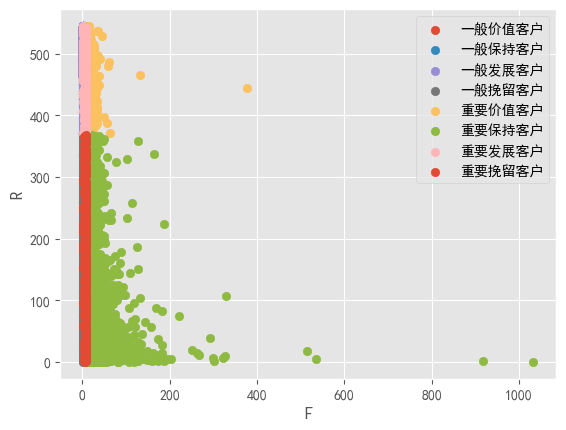

In [19]:
# 客户分层可视化
import matplotlib.pyplot as plt
for label,grouped in rfm.groupby('label'):
    # print(label, grouped)
    x = grouped['F']    # 单个用户的购买数量
    y = grouped['R']   # 最近一次购买时间与 98 年 7 月的相差天数
    plt.scatter(x, y, label=label)
plt.legend()
plt.xlabel('F')
plt.ylabel('R')

    b. 新老，活跃，回流用户分析

    - 新用户的定义是第一次消费。
    - 活跃用户即老客，在某一个时间窗口内有过消费。
    - 不活跃用户则是时间窗口内没有消费过的老客。
    - 回流用户:相当于回头客的意思。
    - 用户回流的动作可以分为自主回流与人工回流，自主回流指玩家自己回流了，而人工回流则是人为参与导致的。

In [20]:
pivoted_counts = df.pivot_table(
                    index='user_id',
                    columns='month', 
                    values='order_dt',
                    aggfunc='count'    
).fillna(0)
pivoted_counts.head()

month,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06
user_id,,,,,,,,,,,,,,,,,,
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0


In [21]:
# 由于浮点数不直观, 需要转换成是否消费即可, 用0、1表示

df_purchase = pivoted_counts.applymap(lambda x:1 if x> 0 else 0)
# apply：       作用于 DataFrame 数据中的一行或一列数据
# applymap:     作用于 DataFrame 数据中的每一个元素
# map:          本身是一个Series的函数, 在 df 结构中无法使用 map 函数, map函数用于 series中的每一个元素

df_purchase.head()

C:\Users\Rainbow\AppData\Local\Temp\ipykernel_11472\2112961940.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_purchase = pivoted_counts.applymap(lambda x:1 if x> 0 else 0)


month,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06
user_id,,,,,,,,,,,,,,,,,,
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
4,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
5,1,1,0,1,1,1,1,0,1,0,0,1,1,0,0,0,0,0


In [22]:
# 判断是否是新用户, 不活跃用户, 新用户

def active_status(data):   # data : 整行数据. 共 18 列
    '''
    功能：
        这个函数 active_status 的功能是根据给定的用户消费数据，将用户按照其消费行为分为不同的状态，
        包括："unreg"（未注册）、"new"（新用户）、"active"（活跃用户）、"unactive"（不活跃用户）、"return"（回流用户）。
    '''
    # 定义一个空列表 status 用来存储每个月的用户状态。
    status= []    # 负责 储存 18 个月的状态:  unreg|new|active|unactive|return

    # 逐个月判断用户状态，并存储到 status 列表中。
    for i in range(18):
        # 本月没消费
        # 如果本月没有消费（即消费额为0），则根据前一个月的状态判断当前月的用户状态。
        if data[i] == 0:
            if len(status) == 0:                    
                status.append('unreg')
            else:                                   
                #若前一个月状态为未注册（'unreg'），则本月状态仍为未注册；否则，本月状态为不活跃（'unactive'）。
                if status[i-1] == 'unreg':          
                    status.append('unreg') 
                else:                               
                    status.append('unactive')       
        
        # 本月有消费 == 1
        # 如果本月有消费，则根据前一个月的状态判断当前月的用户状态。
        else:
            if len(status) == 0:                    # 前面没有任何记录（97年1月份）
                status.append('new')                # 第一次消费
            else:
                # 若前一个月状态为不活跃（'unactive'），则本月状态为回流（'return'）；
                if status[i-1] =='unactive':
                    status.append('return')
                # 若前一个月状态为未注册（'unreg'），则本月状态为新用户（'new'）；
                elif status[i-1] == 'unreg':
                    status.append('new')            # 第一次消费
                else:                               # new|active|return = 1 
                    # 否则，本月状态为活跃（'active'）。
                    status.append('active')         # 本月消费过
    
    # 返回一个 Pandas Series 对象，其中包含了每个月对应的用户状态，并且列名与原始数据的列名相同
    return pd.Series(status, df_purchase.columns)   # 值status, 列名 df_purchase 中的列名

purchase_statues = df_purchase.apply(active_status, axis=1)            # 得到用户分层结果
purchase_statues.head()

C:\Users\Rainbow\AppData\Local\Temp\ipykernel_11472\595597428.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if data[i] == 0:


month,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06
user_id,,,,,,,,,,,,,,,,,,
1,new,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive
2,new,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive
3,new,unactive,return,active,unactive,unactive,unactive,unactive,unactive,unactive,return,unactive,unactive,unactive,unactive,unactive,return,unactive
4,new,unactive,unactive,unactive,unactive,unactive,unactive,return,unactive,unactive,unactive,return,unactive,unactive,unactive,unactive,unactive,unactive
5,new,active,unactive,return,active,active,active,unactive,return,unactive,unactive,return,active,unactive,unactive,unactive,unactive,unactive


In [23]:
# 用 nan 替换 unreg
purchase_statues_ct = purchase_statues.replace('unreg', np.NaN).apply(lambda x: pd.Series(x).value_counts())
purchase_statues_ct.head(60)

month,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06
active,NaN,1157.0,1681,1773.0,852.0,747.0,746.0,604.0,528.0,532.0,624.0,632.0,512.0,472.0,571.0,518.0,459.0,446.0
new,7846.0,8476.0,7248,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
return,NaN,NaN,595,1049.0,1362.0,1592.0,1434.0,1168.0,1211.0,1307.0,1404.0,1232.0,1025.0,1079.0,1489.0,919.0,1029.0,1060.0
unactive,NaN,6689.0,14046,20748.0,21356.0,21231.0,21390.0,21798.0,21831.0,21731.0,21542.0,21706.0,22033.0,22019.0,21510.0,22133.0,22082.0,22064.0


<Axes: xlabel='month'>

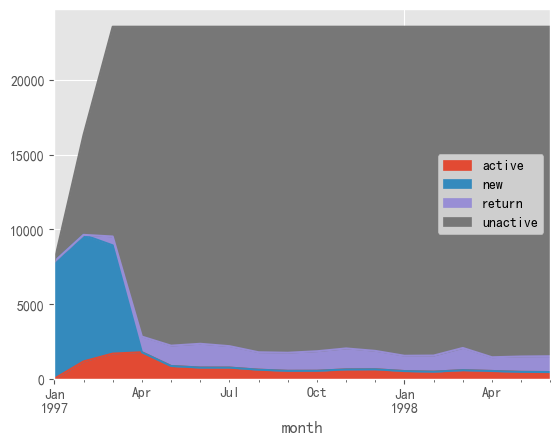

In [24]:
purchase_statues_ct.T.fillna(0).plot.area()         # .T 行列转换

# 前三个月可知，红色活跃用户和蓝色新用户，占比较大
# 四月份过后，新用户和活跃用户，开始下降，并且呈现稳定趋势
# 回流用户主要产生在4月过后，呈现稳定趋势，是网站的重要客户

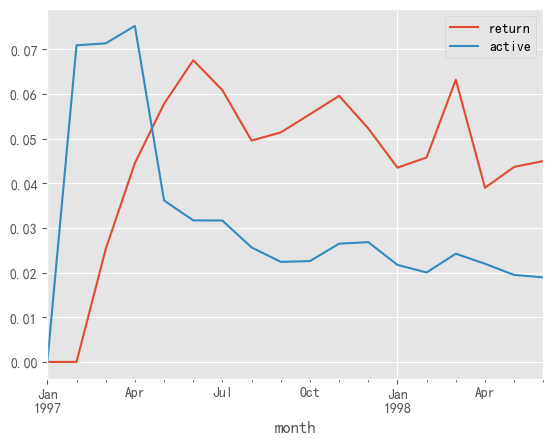

In [25]:
# 回流用户的占比
return_rate = purchase_statues_ct.T.fillna(0).apply(lambda x: x/x.sum(), axis=1)
return_rate['return'].plot()
return_rate['active'].plot()

plt.legend()

#  回流用户:前五个月，回流用户上涨，过后呈现下降趋势，平均维持在5%比例
#  活跃用户:前三个月活跃用户大量增长，猜测由于活动新引来很多新用户所导致. 5月份过后开始下降，平均维持在2.5%左右
#  网站运营稳定后，回流用户占比大于活跃用户

    c. 用户购买周期分析
      
用户每次购物之间的时间间隔为用户购买周期

In [26]:
# shift 函数: 将数据移动到一定的位置

data1 = pd.DataFrame({
    'a':[0, 1, 2, 3, 4, 5],
    'b':[5, 4, 3, 2, 1, 0]
})
data1.shift(axis=0)   # 整体向下移动一个位置（默认值: axis=0）
data1.shift(axis=1)

,a,b
0,NaN,0
1,NaN,1
2,NaN,2
3,NaN,3
4,NaN,4
5,NaN,5


In [27]:
# 计算购买周期 (购买日期的时间差值)
order_diff = df.groupby('user_id').apply(lambda x:x['order_date']-x['order_date'].shift())    # 当前订单日期 - 上一次订单日期
order_diff.describe()


C:\Users\Rainbow\AppData\Local\Temp\ipykernel_11472\3001303182.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  order_diff = df.groupby('user_id').apply(lambda x:x['order_date']-x['order_date'].shift())    # 当前订单日期 - 上一次订单日期


count                         46089
mean     68 days 23:22:13.567662566
std      91 days 00:47:33.924168893
min                 0 days 00:00:00
25%                10 days 00:00:00
50%                31 days 00:00:00
75%                89 days 00:00:00
max               533 days 00:00:00
Name: order_date, dtype: object

<Axes: >

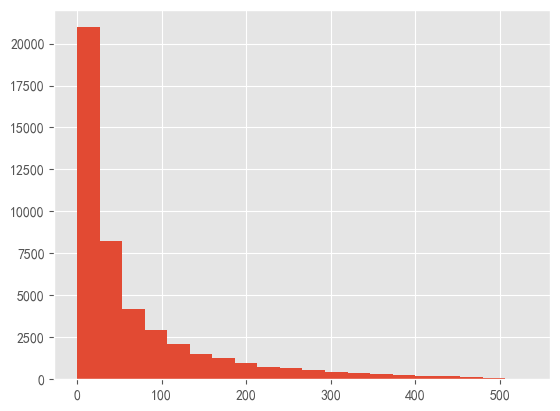

In [28]:
(order_diff/np.timedelta64(1, 'D')).hist(bins=20)    # bins 参数影响柱子的宽度    每个柱子的宽度=(最大值-最小值)/bins

# 得知:
# 1.平均消费周期为68天
# 2. 大多数消费周期低于100天
# 3. 直方图呈现典型的长尾分布, 只有小部分用户消费周期在200天以上(不积极消费的用户)，
#       可以在这批用户消费后3天左右进行电话回访或者短信赠送优惠卷等活动, 增大消费频率

    d. 用户生命周期分析

用户第一次购物与最后一次购物的时间间隔为用户生命周期

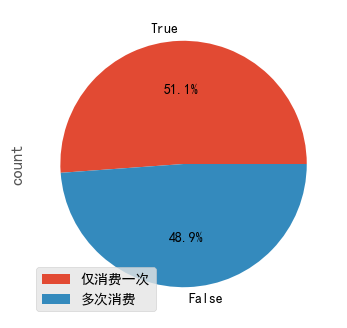

In [35]:
# 计算方式: 用户最后一次购买日期 - 第一次购买的日期.  如果 差值 == 0, 说明用户仅仅够买了一次

user_life = df.groupby('user_id')['order_date'].agg(['min', 'max'])
(user_life['max']==user_life['min']).value_counts().plot.pie(autopct='%1.1f%%',figsize=(18,4))   # 格式化成1位小数
plt.legend(['仅消费一次', '多次消费'])
# 一半以上的用户仅仅消费了一次，说明运营不利，留存率不好

In [36]:
(user_life['max']-user_life['min']).describe()    # 生命周期分析

# 用户平均生命周期为134天，但是中位数==0，再次验证大多数用户消费了一次，低质量用户
# 75%分位数以后的用户,生命周期>294天, 属于核心用户, 需要着重维持。
# 前三个月的新用户数据，所以分析的是这些用户的生命周期

count                          23570
mean     134 days 20:55:36.987696224
std      180 days 13:46:43.039788104
min                  0 days 00:00:00
25%                  0 days 00:00:00
50%                  0 days 00:00:00
75%                294 days 00:00:00
max                544 days 00:00:00
dtype: object

Text(0, 0.5, '用户数')

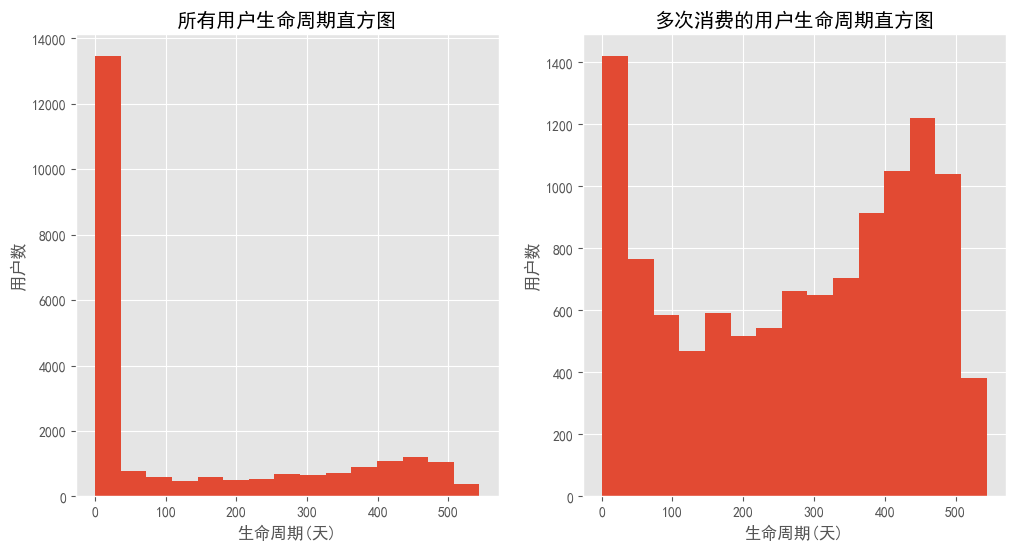

In [45]:
# 绘制所有用户生命周期直方图  + 多次消费

plt.figure(figsize=(12, 6))

plt.subplot(121)
((user_life['max']-user_life['min'])/np.timedelta64(1,'D')).hist(bins=15)
plt.title('所有用户生命周期直方图')
plt.xlabel('生命周期(天)')
plt.ylabel('用户数')

plt.subplot(122)
u_1 = ((user_life['max']-user_life['min']).reset_index()[0]/np.timedelta64(1, 'D'))
u_1[u_1>0].hist(bins=15)
plt.title('多次消费的用户生命周期直方图')
plt.xlabel('生命周期(天)')
plt.ylabel('用户数')

#  对比可知 : 第二幅图过滤掉了 生命周期 == 0 的用户， 呈现双峰结构
# 虽然二图中， 还有一部分用户生命周期趋于0天， 但比第一幅图好了很多，虽然进行了多次消费，但是不成长期
# 来消费，属于普通用户，可针对性进行营销推广活动
#  少部分用户生命周期集中在300~500天，属于我们的忠诚客户，需要大力度维护此类客户

### 6、 复购率和回购率分析

    a. 复购率

C:\Users\Rainbow\AppData\Local\Temp\ipykernel_11472\318846903.py:17: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  purchase_r = pivoted_counts_1.applymap(lambda x: 1 if x>1 else np.NaN  if x ==0 else 0)


Text(0, 0.5, '复购率')

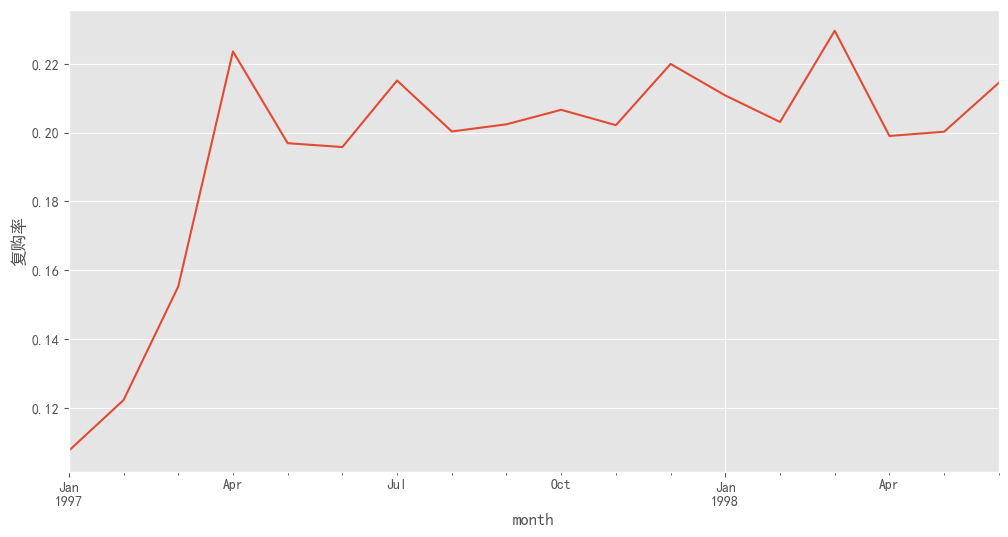

In [54]:
# 计算方式: 在自然月内, 购买多次的用户在总消费人数中的占比（若客户在同一天消费了多次，也称之复购用户）

#  消费者有三种:
#       1、消费记录>=2次的
#       2、消费总人数
#       3、本月无消费用户


pivoted_counts_1 = df.pivot_table(
                    index='user_id',
                    columns='month', 
                    values='order_dt',
                    aggfunc='count'    
).fillna(0)

#  复购用户 : 1     非复购的消费用户 : 0    自然月没有消费的用户 : NAN (不参与count计数)
purchase_r = pivoted_counts_1.applymap(lambda x: 1 if x>1 else np.NaN  if x ==0 else 0)
purchase_r.head()
# purchase_r.sum()  : 求出复购用户
#  purchase_r.count()  : 求出所有参与购物的用户(NAN不参与计数)
(purchase_r.sum()/purchase_r.count()).plot(figsize=(12,6))
plt.ylabel('复购率')

#   前三个月复购率开始上升，后续趋于平稳维持在20%~22%之间。
#  分析前三个月复购率低的原因，可能是因为大批新用户仅仅购买一次造成的。


    b. 回购率

In [62]:
#  计算方式: 
# 在一个时间窗口内进行了消费，在下一个窗口内又进行了消费
import numpy as np

def purchase_back(data):
    status=[]       #存储用户回购率状态
    #  1: 回购用户  0: 非回购用户 (当前月消费了，下个未消费)   NaN:当前月份未消费
    for i in range(len(data)-1):
        #  当前月份消费了
        if data.iloc[i] == 1:
            #  下一个月份消费了
            if data.iloc[i+1] == 1:
                status.append(1)    # 回购用户
            #  下一个月份没消费
            elif data.iloc[i+1] == 0:
                status.append(0)    # 非回购用户
        else:
            status.append(np.NaN)
    status.append(np.NaN)           # 填充最后一列数据
    return pd.Series(status, df_purchase.columns)


pivoted_counts = df.pivot_table(
                    index='user_id',
                    columns='month', 
                    values='order_dt',
                    aggfunc='count'    
).fillna(0)

df_purchase = pivoted_counts.apply(lambda x: x.apply(lambda y: 1 if y > 0 else 0))


purchase_b = df_purchase.apply(purchase_back, axis = 1)
purchase_b.head()


month,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06
user_id,,,,,,,,,,,,,,,,,,
1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN
4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
5,1.0,0.0,NaN,1.0,1.0,1.0,0.0,NaN,0.0,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN


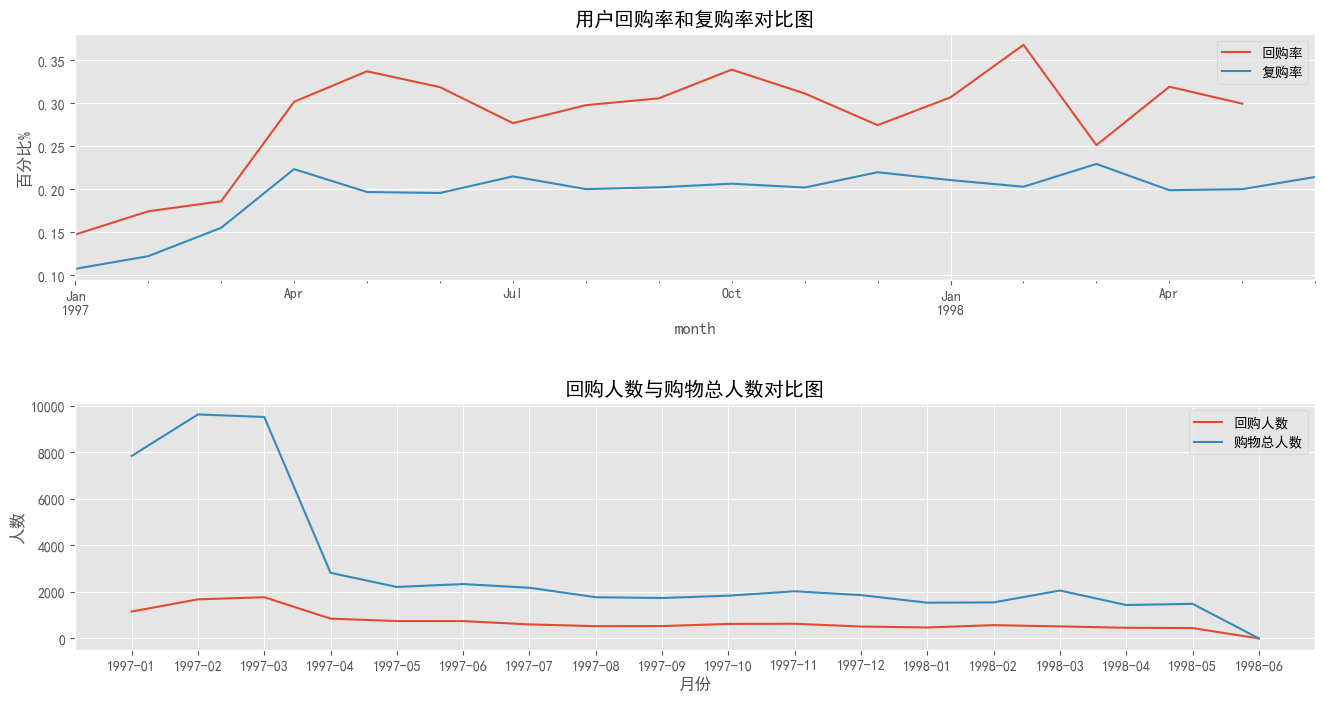

In [81]:
#  回购率可视化
plt.figure(figsize=(16,8))
plt.subplot(211)

# 回购率
purchase_back_rate = purchase_b.sum() / purchase_b.count()
purchase_back_rate.plot(label='回购率')

#  复购率
(purchase_r.sum()/purchase_r.count()).plot(label='复购率')
plt.legend()
plt.ylabel('百分比%')
plt.title('用户回购率和复购率对比图')

#   回购率可知，平稳后在30%左右，波动性稍微较大
#   复购率低于回购率，平稳后在20%左右，波动性较小
#   前三个月不管是回购还是复购，都呈现上升趋势，说明新用户需要一定时间来变成复购或者回购用户

#   结合新老用户分析，新客户忠诚度远低于老客户忠诚度

plt.subplots_adjust(hspace=0.5)

#  回购人数与购物总人数
purchase_b_sum = purchase_b.sum()
purchase_b_count = purchase_b.count()

# Convert Period objects to strings representing year-month
purchase_b_sum.index = purchase_b_sum.index.strftime('%Y-%m')
purchase_b_count.index = purchase_b_count.index.strftime('%Y-%m')

# Plot the sum and count
plt.subplot(212)
plt.plot(purchase_b_sum, label='回购人数')
plt.plot(purchase_b_count, label='购物总人数')
plt.title('回购人数与购物总人数对比图')
plt.xlabel('月份')
plt.ylabel('人数')
plt.legend()

#  前三个月购物总人数远远大于回购人数，主要是因为很多新用户在1月份进了首次购买
#  三个月后，回购人数和购物总数开始稳定，回购人数稳定在1000左右，购物总人数在2000左右。 

### 7、结论

1. 整体趋势:按年的月份趋势销量和销售额在1-3月份相对极高，然后骤降，原因可能跟这段时间的大力促销或与商品的季度属性有关

2. 用户个体特征:每笔订单的金额和商品购买量都集中在区间的低段水平，都是小金额小批量进行购买，此类交易群体，可在丰富产品线和增加促销活动提高转换率和购买率。

3. 大部分用户的消费总额和购买总量都集中刚在低段，长尾分布，这个跟用户需求有关，可以对商品进行多元文化价值的赋予，增强其社交价值属性，提高用户的价值需求。

4. 用户的消费周期:有二次以上消费的用户，平均68天，所以在50天到60天期间，应该对这批用户进行刺激召回，细致点，比010天回复满意度，30天发放优惠券，55天的时候提醒优惠券的使用。

5. 用户的生命周期:有二次及以上消费的用户的平均生命周期是276天。用户的生命周期分别在20天内与400至500天间，应该在20天内对客户进行引导，促进其再次消费并形成消费习惯，延长其生命周期;在100至400天的用户，也要根据其特点推出有针对性的营销活动，引导其持续消费。

6. 新客户的复购率约为12%，老客户的复购率在20%左右;新客户的回购率在15%左右，老客户的回购率在30%左右，需要营销策略积极引导其再次消费及持续消费。

7. 用户质量:用户个体消费有一定规律性，大部分用户的消费集中在2000以下，用户消费反应了2/8法则，消费排名前20%的用户贡献了80%的消费额，所以说，狠抓高质量用户是万古不变的道理，这些高质量客户都是“会员”类型，需要专门为会员优化购物体验，比如专线接听、特殊优惠等等。

#### 方法总结



1. 针对用户进行按照月份做整体和个体分析，主要分析维度是人数，消费金额，购买量

2. 消费分析:首购时间，最后一次购买时间，相邻两个购物时间的间隔，用户分层(RFM模型+数据透视表),分析维度主要是新用户，活跃用户，不活跃用户流失分析，回流用户占比

3. 复购率和回购率进行分析